This code produces all figures as well as summary statistics reported in the main paper and supplement. It has to be run after the analysis code `OIC-OO v6` and the results processing code `OSM Results Processing`, using the same ControlFile and from the same folder; this code will read the processed .tab files from the analysis, and will fail if they are not available. See main `Analysis Code` folder for `ReadMe` with explanation of ControlFile format and fields.

In [1]:
import os
import json
import regex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
import matplotlib.cm as cm

from shutil import copy
from distutils.dir_util import copy_tree

In [2]:
# Read specified controlfile and unpack into variables
controlfilename = input("Enter control file name (with extension):")
cf = json.load(open(controlfilename, 'r'))

for k,v in cf.items():
    exec(k + '=v')

for setting in [analysissettings]:
    for k, v in setting.items():
        exec(k + '=v')

# Initialise base working directory
os.chdir(f"{baserunname}_IterCal")
basedir = os.getcwd()
os.chdir('./Results')

Enter control file name (with extension): OICC0607.txt


In [17]:
## PLOT ANNUAL POLICY PROJECTION GRAPHS ##

pollist = ['Bup Providers', 'Bup Prov Capacity', 'Diverted Rx Init', 
           'Fent OD Risk', 'Heroin Init', 'MMT Capacity', 'Nx Kits', 'Own Rx Init', 
           'Peer Recovery', 'Return to OUD', 'People with Rx', 'Developing OUD', 'XR-NTX Capacity']

annpolproj = pd.read_csv(f'X3_polprojperc.tab', sep = '\t', index_col=[0,1,2])
annpolproj.columns = annpolproj.columns.astype(float)

ap = annpolproj.loc[:, endyear+2.:]

display(ap)

plt.rc('font', size=12)

# formats = pd.DataFrame({"color":['0.35', 'k'],
#                        "linetype":['-', '--'],
#                        "fillcolor":['0.4','k']},
#                      index = ['Total overdose deaths', 'Total with UD'])

# formats = pd.DataFrame({"color":['darkorchid', 'forestgreen'],
#                        "linetype":['-', '--'],
#                        "fillcolor":['darkorchid','forestgreen']},
#                      index = ['Total overdose deaths', 'Total with UD'])

formats = pd.DataFrame({"color":['crimson', 'dodgerblue'],
                       "linetype":['-', '--'],
                       "fillcolor":['crimson','dodgerblue']},
                     index = ['Total overdose deaths', 'Total with UD'])

for scen in pollist:
    fig1, ax = plt.subplots(figsize=[4.5, 4.2])
    s = ap.loc[scen]
    #lines = [ax.plot(s.loc[var, 'EV']) for var in projvars]
    for var in polvars:
        linecolor = formats.loc[var, 'color']
        linetype = formats.loc[var, 'linetype']
        fillcolor = formats.loc[var, 'fillcolor']
        ax.plot(s.loc[var, 'EV']*100, c=linecolor, linestyle=linetype)
        ax.fill_between(s.columns, s.loc[var, str(0.025)]*100, s.loc[var, str(0.975)]*100, alpha=0.2, 
                        color=fillcolor, edgecolor=None)
        ax.plot([2021, 2031], [0, 0], 'k', linestyle=':', lw=1) # reference line at y=0
        ax.set_ylim([-14, 2])
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))
        loc = mticker.MultipleLocator(base=1)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelrotation=90)
    fig1.tight_layout()
    fig1.savefig(f'Figures/{scen}.svg')
    fig1.clf()

2021.00   2021.25   2021.50  \
Scen               Var                   Perc                                 
Bup Providers      Total overdose deaths 0.025      0.0 -0.000047 -0.000097   
                                         0.05       0.0 -0.000046 -0.000094   
                                         0.5        0.0 -0.000039 -0.000077   
                                         0.9        0.0  0.000000  0.000000   
                                         0.975      0.0  0.000000  0.000000   
...                                                 ...       ...       ...   
XR-NTX Capacity 50 Total with UD         0.05       0.0 -0.000042 -0.000146   
                                         0.5        0.0 -0.000037 -0.000125   
                                         0.9        0.0 -0.000034 -0.000113   
                                         0.975      0.0 -0.000032 -0.000107   
                                         EV         0.0 -0.000039 -0.000134   

                                                 2021.75   2022.00   2022.25  \
Scen               Var                   Perc                                  
Bup Providers      Total overdose deaths 0.025 -0.000129 -0.000149 -0.000162   
                                         0.05  -0.000125 -0.000144 -0.000155   
                                         0.5   -0.000101 -0.000114 -0.000119   
                                         0.9    0.000000  0.000000  0.000000   
                                         0.975  0.000000  0.000000  0.000000   
...                                                  ...       ...       ...   
XR-NTX Capacity 50 Total with UD         0.05  -0.000304 -0.000517 -0.000787   
                                         0.5   -0.000254 -0.000422 -0.000630   
                                         0.9   -0.000224 -0.000366 -0.000534   
                                         0.975 -0.000209 -0.000337 -0.000489   
                                         EV    -0.000282 -0.000440 -0.000645   

                                                 2022.50   2022.75   2023.00  \
Scen               Var                   Perc                                  
Bup Providers      Total overdose deaths 0.025 -0.000169 -0.000172 -0.000170   
                                         0.05  -0.000161 -0.000161 -0.000160   
                                         0.5   -0.000120 -0.000116 -0.000078   
                                         0.9    0.000000  0.000000  0.000000   
                                         0.975  0.000000  0.000000  0.000000   
...                                                  ...       ...       ...   
XR-NTX Capacity 50 Total with UD         0.05  -0.001108 -0.001476 -0.001889   
                                         0.5   -0.000875 -0.001152 -0.001452   
                                         0.9   -0.000731 -0.000950 -0.001177   
                                         0.975 -0.000666 -0.000857 -0.001025   
                                         EV    -0.000897 -0.001190 -0.001533   

                                                 2023.25  ...   2028.75  \
Scen               Var                   Perc             ...             
Bup Providers      Total overdose deaths 0.025 -0.000165  ... -0.000018   
                                         0.05  -0.000156  ... -0.000016   
                                         0.5   -0.000050  ... -0.000003   
                                         0.9    0.000000  ...  0.000000   
                                         0.975  0.000000  ...  0.000003   
...                                                  ...  ...       ...   
XR-NTX Capacity 50 Total with UD         0.05  -0.002360  ... -0.007962   
                                         0.5   -0.001780  ... -0.003599   
                                         0.9   -0.001406  ... -0.000654   
                                         0.975 -0.001110  ... -0.000289   
                                      

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

,,2021,2021.25,2021.5,2021.75,2022,2022.25,2022.5,2022.75,2023,2023.25,...,2028.75,2029,2029.25,2029.5,2029.75,2030,2030.25,2030.5,2030.75,2031
Scenario,Var,,,,,,,,,,,,,,,,,,,,,
Baseline,Projected cumulative UD person years,0.0,773100.000000,1.529010e+06,2.267620e+06,2.988960e+06,3.693350e+06,4.381250e+06,5.052750e+06,5.708350e+06,6.348250e+06,...,1.711765e+07,1.748985e+07,1.785445e+07,1.821195e+07,1.856235e+07,1.890615e+07,1.924345e+07,1.957465e+07,1.989985e+07,2.021945e+07
Bup Providers,Projected cumulative UD person years,0.0,773100.000000,1.529000e+06,2.267600e+06,2.988930e+06,3.693350e+06,4.381150e+06,5.052750e+06,5.708250e+06,6.348150e+06,...,1.711745e+07,1.748975e+07,1.785435e+07,1.821185e+07,1.856225e+07,1.890605e+07,1.924335e+07,1.957445e+07,1.989975e+07,2.021925e+07
Bup Providers 10,Projected cumulative UD person years,0.0,773100.000000,1.529000e+06,2.267610e+06,2.988940e+06,3.693350e+06,4.381150e+06,5.052750e+06,5.708350e+06,6.348150e+06,...,1.711755e+07,1.748975e+07,1.785445e+07,1.821185e+07,1.856235e+07,1.890605e+07,1.924345e+07,1.957455e+07,1.989975e+07,2.021935e+07
Bup Providers 50,Projected cumulative UD person years,0.0,773100.000000,1.528990e+06,2.267580e+06,2.988890e+06,3.693250e+06,4.381050e+06,5.052650e+06,5.708250e+06,6.348050e+06,...,1.711735e+07,1.748955e+07,1.785425e+07,1.821165e+07,1.856215e+07,1.890585e+07,1.924325e+07,1.957435e+07,1.989955e+07,2.021915e+07
Bup Prov Capacity,Projected cumulative UD person years,0.0,773020.000000,1.528370e+06,2.266130e+06,2.986760e+06,3.690650e+06,4.377950e+06,5.049150e+06,5.704350e+06,6.343950e+06,...,1.711035e+07,1.748255e+07,1.784715e+07,1.820455e+07,1.855505e+07,1.889875e+07,1.923605e+07,1.956715e+07,1.989235e+07,2.021195e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
People with Rx 10,% change in Projected total with UD,0.0,-0.000020,-1.040115e-04,-2.541986e-04,-4.713679e-04,-7.564814e-04,-1.117879e-03,-1.545665e-03,-2.052005e-03,-2.626275e-03,...,-2.538623e-02,-2.665596e-02,-2.794343e-02,-2.926097e-02,-3.058660e-02,-3.193282e-02,-3.329809e-02,-3.468102e-02,-3.607987e-02,-3.749308e-02
People with Rx 50,% change in Projected total with UD,0.0,-0.000108,-5.267679e-04,-1.274428e-03,-2.363875e-03,-3.804021e-03,-5.596774e-03,-7.739663e-03,-1.022131e-02,-1.303220e-02,...,-1.047840e-01,-1.095629e-01,-1.144258e-01,-1.193808e-01,-1.244260e-01,-1.295491e-01,-1.347744e-01,-1.400909e-01,-1.455009e-01,-1.510083e-01
XR-NTX Capacity,% change in Projected total with UD,0.0,-0.000013,-5.368335e-05,-1.133588e-04,-1.758836e-04,-2.593651e-04,-3.578689e-04,-4.761707e-04,-6.156014e-04,-7.656664e-04,...,-1.659535e-03,-1.564796e-03,-1.471803e-03,-1.387984e-03,-1.299714e-03,-1.221675e-03,-1.139678e-03,-1.068988e-03,-9.948779e-04,-9.252669e-04


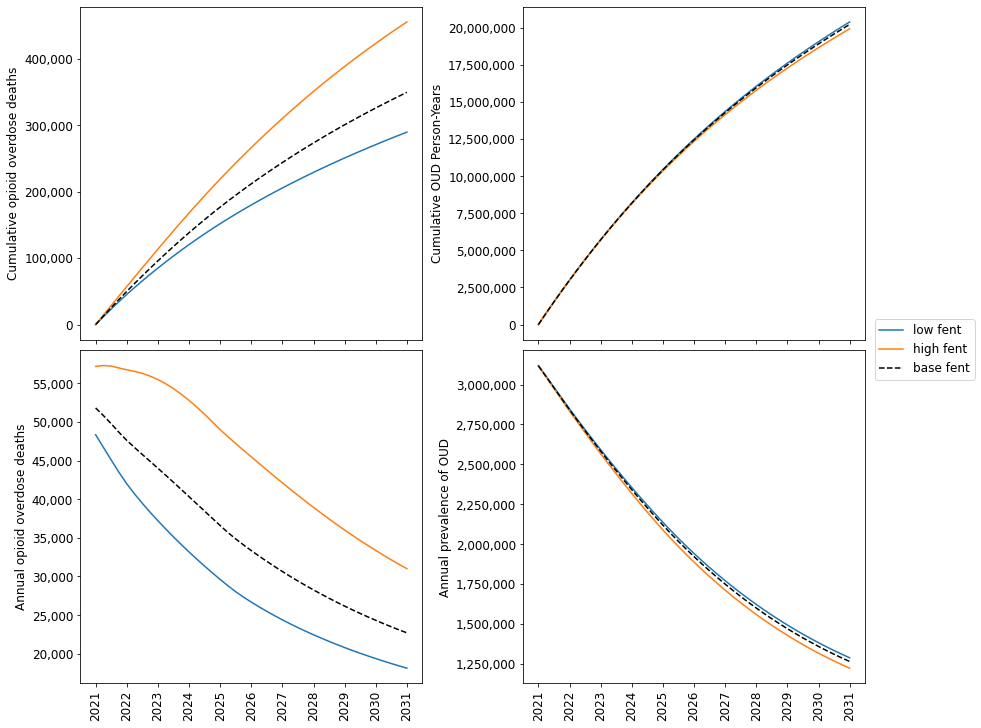

In [9]:
## PLOT CUMULATIVE FENTANYL GRAPHS ##
outcomes = ['Cumulative opioid overdose deaths', 'Cumulative OUD Person-Years',
        'Annual opioid overdose deaths', 'Annual prevalence of OUD']
fent = ['low fent', 'high fent', 'base fent']

lofent = pd.read_csv(f'X3_FentL_PolRes.tab', sep='\t', index_col=[1, 0])
hifent = pd.read_csv(f'X3_FentH_PolRes.tab', sep='\t', index_col=[1, 0])
basefent = pd.read_csv(f'X3_Base_PolRes.tab', sep='\t', index_col=[1, 0])

display(basefent)

lf = lofent.loc['Baseline'].loc['Projected cumulative UD person years':'Projected total with UD']
hf = hifent.loc['Baseline'].loc['Projected cumulative UD person years':'Projected total with UD']
bf = basefent.loc['Baseline'].loc['Projected cumulative UD person years':'Projected total with UD']

allf = pd.concat([lf, hf, bf], keys = ['low fent', 'high fent', 'base fent']).swaplevel(i=0, j=1, axis=0)

allf.rename(index={'Projected cumulative overdose deaths':'Cumulative opioid overdose deaths',
                   'Projected cumulative UD person years': 'Cumulative OUD Person-Years',
                   'Projected total overdose deaths':'Annual opioid overdose deaths',
                   'Projected total with UD':'Annual prevalence of OUD'
                  }, inplace=True)
allf.index.set_names('Fentanyl Level', level=1, inplace=True)


formats = pd.DataFrame({"color":['tab:blue', 'tab:orange', 'k'],
                       "linetype":['-', '-', '--']},
                     index = ['low fent', 'high fent', 'base fent'])

fig4, axs = plt.subplots(2, 2, figsize=[12, 10], sharex=True, constrained_layout=True) 

for ax, var in zip(axs.flatten(), outcomes):
    s = allf.loc[var]
    for scen in fent:
        linecolor = formats.loc[scen, 'color']
        linetype = formats.loc[scen, 'linetype']
        ax.plot(s.loc[scen], c=linecolor, linestyle=linetype, label=scen)
        loc = mticker.MultipleLocator(base=4)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelrotation=90)
        ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    ax.set_ylabel(str(var))
fig4.legend(['low fent', 'high fent', 'base fent'], loc='center right', bbox_to_anchor = (1.13, 0.52))
fig4.savefig(f'Figures/fentscenarios.svg', bbox_inches='tight')

In [ ]:
##### SEND MAIN OUTPUTS TO SUBFOLDER FOR EASY ACCESS #####

os.chdir(basedir)
os.chdir('./Results')
os.makedirs('./ResMain', exist_ok=True)

resmain = ['assm_sens.tab', 'GOF.tab', 'inputs.tab', 'lk_sens.tab', 'params.tab', 
           'polproj.tab', 'proj_changes.tab', 'syndata_means.tab', 'yearvals.tab', 
           'summary.txt']

for res in resmain:
    copy(f'./{baserunname}_{res}', './ResMain')
